### Dependency installation

In [1]:
!pip install trl
!pip uninstall transformers --Y
!pip install --no-cache-dir transformers sentencepiece


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: --Y


### Reading Wiki Dataset

In [2]:
import json
import logging
import pandas as pd

## Run it to download data from gg drive

import gdown

# Google Drive file ID
file_id = '1ilZo8_cbIp0GidXCzfojGwVsrGvEwiwP'
# Construct download URL
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
gdown.download(url, 'GPT-intro-processed.csv', quiet=False)


In [3]:
file_path = 'GPT-intro-processed.csv'
df = pd.read_csv(file_path)
df.head(5)

,id,wiki_intro,generated_intro
0,63064638,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...
1,279621,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an..."
2,287229,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc..."
3,26712375,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...
4,38894426,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ..."


In [4]:
alt_df=df.copy()

#### Get human text H corpus, AI-generated M corpus and Validation data

In [5]:
# Get 10% of data as validation set
sample_size = int(0.10 * len(alt_df))
validate_df = alt_df.sample(n=sample_size, random_state=42)
alt_df = alt_df.drop(validate_df.index)
validate_df.head(10)

,id,wiki_intro,generated_intro
59770,28309756,The Benetton B187 is a Formula One racing car ...,The Benetton B187 is a Formula One racing car ...
21362,2387525,The Heliodisplay is an air-based display using...,The Heliodisplay is an air-based display using...
127324,15214263,"Mitochondrial carrier homolog 1 (MTCH1), also ...","Mitochondrial carrier homolog 1 (MTCH1), also ..."
140509,636846,"Calluna vulgaris, common heather, ling, or sim...","Calluna vulgaris, common heather, ling, or sim..."
144297,36667499,Berea–Midpark High School (BMHS) is a public h...,Berea–Midpark High School (BMHS) is a public h...
96370,8776164,Sparta Amfi is an indoor ice hockey rink locat...,Sparta Amfi is an indoor ice hockey rink locat...
49742,64656506,Jagdish Mahto was a naxal leader who led the B...,Jagdish Mahto was a naxal leader who was activ...
47389,31806743,"Barbara Fish Lee (born July 3, 1945) is an Ame...","Barbara Fish Lee (born July 3, 1945) is an Ame..."
58378,1856662,Volodymyr Antonovych (Ukrainian: Володимир Бон...,Volodymyr Antonovych (Ukrainian: Володимир Бон...
69047,32939850,Tiit is predominantly an Estonian masculine gi...,Tiit is predominantly an Estonian masculine gi...


In [6]:
validate_df = validate_df.sample(frac=1).reset_index(drop=True)

# Select the first 10 rows from 'wiki_intro' and 'generated_intro'
validation_data = validate_df.loc[:9, ['wiki_intro', 'generated_intro']]

# Convert the selected rows to a list of tuples
validation_data = [tuple(x) for x in validation_data.values]

In [7]:
# validation_data

## Baseline Implementation - RADAR on Wiki dataset

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, AdamW
import torch
import torch.optim as optim
import random
import numpy as np
from trl import PPOConfig,AutoModelForSeq2SeqLMWithValueHead,PPOTrainer,AutoModelForCausalLMWithValueHead,create_reference_model
from transformers import AutoTokenizer
from trl.core import respond_to_batch
import torch
import torch.nn.functional as F
from torch import Tensor
# from transformers.generation.utils import top_k_top_p_filtering

/home/ea301b/anaconda3/envs/binh_mamba/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def top_k_top_p_filtering(
    logits: Tensor,
    top_k: int = 0,
    top_p: float = 1.0,
    filter_value: float = -float("Inf"),
    min_tokens_to_keep: int = 1,
) -> Tensor:
    """Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
    Args:
        logits: logits distribution shape (batch size, vocabulary size)
        if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
        if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
            Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
        Make sure we keep at least min_tokens_to_keep per batch example in the output
    From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Step 1: Paraphraser - Ensemble Paraphraser
https://huggingface.co/ramsrigouthamg/t5-large-paraphraser-diverse-high-quality

https://huggingface.co/eugenesiow/bart-paraphrase

https://huggingface.co/tuner007/pegasus_paraphrase

In [11]:
paraphraser_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained('eugenesiow/bart-paraphrase').to(device)
paraphraser_tokenizer = AutoTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
paraphraser_tokenizer.pad_token = paraphraser_tokenizer.eos_token
para_ref = create_reference_model(paraphraser_model).to(device)


/home/ea301b/anaconda3/envs/binh_mamba/lib/python3.12/site-packages/trl/models/modeling_base.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = loading_func(

In [12]:
paraphraser2_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained('ramsrigouthamg/t5-large-paraphraser-diverse-high-quality').to(device)
paraphraser2_tokenizer = AutoTokenizer.from_pretrained("ramsrigouthamg/t5-large-paraphraser-diverse-high-quality")
paraphraser2_tokenizer.pad_token = paraphraser2_tokenizer.eos_token
para_ref2 = create_reference_model(paraphraser2_model).to(device)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer
# model_name = 'tuner007/pegasus_paraphrase'

# paraphraser3_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
# paraphraser3_tokenizer =  PegasusTokenizer.from_pretrained(model_name)
# paraphraser3_tokenizer.pad_token = paraphraser3_tokenizer.eos_token
# para_ref3 = create_reference_model(paraphraser3_model).to(device)


In [14]:
def get_paraphrase(text, paraphraser_model, paraphraser_tokenizer, device):
    text = "Enhance word choices to make the sentence sound more like a human: " + text + " </s"

    encoding = paraphraser_tokenizer.encode_plus(text, max_length=1024, truncation=False, return_tensors="pt")
    input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

    paraphraser_model.eval()
    beam_outputs = paraphraser_model.generate(
        input_ids=input_ids, attention_mask=attention_mask,
        max_length=10000,
        early_stopping=False,
        num_beams=15,
        num_return_sequences=1
    )

    sent = paraphraser_tokenizer.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return sent[len("paraphrasedoutput: "):]

In [15]:
def get_paraphrase(text, paraphraser_model, paraphraser_tokenizer, device,inp_out = False):
    text = "Enhance word choices to make the sentence sound more like a human: " + text + " </s"
    pm = paraphraser_model.to(device)
    # print("Beginning paraphrasing")
    pt = paraphraser_tokenizer
    encoding = pt.encode_plus(text, max_length=1024, truncation=False, return_tensors="pt")
    input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
    # print("In the middle of paraphrasing")
    pm.eval()
    beam_outputs = pm.generate(
        input_ids=input_ids.to(device), attention_mask=attention_mask.to(device),
        max_length=1000,
        early_stopping=True,
        num_beams=4,
        num_return_sequences=1
    )
    # print("Ending paraphrasing")
    sent = pt.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    # print(sent)
    if inp_out:
      return sent,input_ids,beam_outputs[0]
    else:
      return sent

#### Step 2: RoBERTa Detector (OpenAI)
https://huggingface.co/roberta-large-openai-detector

In [16]:
detector_model = AutoModelForSequenceClassification.from_pretrained("openai-community/roberta-base-openai-detector")
detector_tokenizer = AutoTokenizer.from_pretrained("openai-community/roberta-base-openai-detector")
detector_model.to(device)

Some weights of the model checkpoint at openai-community/roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [17]:
def classify_text(text):
    # Tokenize the text
    inputs = detector_tokenizer(text, return_tensors="pt").to(device)

    # Pass the text through the model
    with torch.no_grad():
        output = detector_model(**inputs)

    # Get the predicted label (1 if AI-generated and 0 if not)
    label = 1 if output.logits[0][0] > output.logits[0][1] else 0

    return label

In [18]:
text = "Sexhow railway station was a railway station located in the town of Sexhow, on the Cumbrian Coast Line in North West England. The station was opened by the Lancashire and Yorkshire Railway on 7 October 1870. It was closed to passengers on 5 January 1950, and to goods on 12 May 1965. The station building is now a private residence. There is a small amount of trackage remaining near the building, used currently by a local agricultural business."
label = classify_text(text)
print(label)

0


### Step 3: Training with reward 

In [19]:
# Initialize hyperparameters
max_steps = 100  # Maximum training steps 100
batch_size = 8 #32
learning_rate = 1e-5
epsilon = 0.2
gamma = 1.0
lambda_val = 0.1

# Initialize replay buffer
replay_buffer = []

human_text_corpus = list(alt_df['wiki_intro'])
AI_text_corpus = list(alt_df['generated_intro'])

# Initialize the optimizer for the paraphraser model
paraphraser_optimizer = optim.Adam(paraphraser_model.parameters(), lr=learning_rate)

# Initialize the old action probabilities
old_action_prob = None

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:

# Training Setup
ppo_config = PPOConfig(
    # batch_size=256,
    # max_steps = 20000,
    learning_rate = 4e-5,
    # lambda = 0.95,
)
ppotrainersteps = {0:[],1:[],2:[]}
loss_detector = []



In [22]:
if len(replay_buffer) >= batch_size:

        paraphraser_model.train()
        paraphraser_optimizer.zero_grad()

        data = random.sample(replay_buffer, batch_size)
        x_p_texts = [item[2] for item in data]
        x_m_texts = [item[1] for item in data]
        # print(x_p_texts)
        # print(x_m_texts)
        # print(rewards)
        query_txt = x_m_texts

        for i in range(2):

            # print(x_p_texts)
            # print(x_p_texts[0][i])
            # print(paraphraser_tokenizer(x_p_texts[0][i], return_tensors="pt").to(device))
            query_tensors = paraphraser_tokenizer(query_txt, return_tensors="pt", padding=True, truncation=True).to(device)

            resp_tensor = paraphraser_tokenizer(x_p_texts[i], return_tensors="pt", padding=True, truncation=True).to(device)['input_ids']
            # print(resp_tensor)
            # print(query_tensor)
            ppo_trainer = PPOTrainer(ppo_config, paraphraser_model, para_ref, paraphraser_tokenizer)

            # define a reward for response
            # (this could be any reward such as human feedback or output from another model)
            qt = query_tensor['input_ids']
            reward = rewards[i]
            print("Reward for model",i+1," ",reward)
            # train model for one step with ppo
            # print(qt)
            train_stats = ppo_trainer.step([qt[0]], [resp_tensor[0]], reward)
            print("PPO Val Loss : ",train_stats['ppo/loss/value'])
            ppotrainersteps[i].append(train_stats['ppo/loss/value'])

In [23]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

detector_model.to(device)

# Initialize tqdm for tracking progress
progress_bar = tqdm(range(max_steps), desc="Training Progress")
# Training Loop
detector_model.to(device)
for step in progress_bar:
    torch.cuda.empty_cache()
    # Sample x_h and x_m from H and M, respectively
    x_h = human_text_corpus[np.random.randint(len(human_text_corpus))]
    x_m = AI_text_corpus[np.random.randint(len(AI_text_corpus))]

    # Calculate the reward using the detector model
    paraphrased_texts = []
    models = [paraphraser_model, paraphraser2_model]
    tokenizers = [paraphraser_tokenizer, paraphraser2_tokenizer]
    inputss = []
    outputss = []
    rewards = []
    for i in range(2):
        paraphrased_text = get_paraphrase(x_m, models[i], tokenizers[i], device,False)
        paraphrased_texts.append(paraphrased_text)
        ip = detector_tokenizer(paraphrased_text, return_tensors="pt", padding=True, truncation=True).to(device)
        inputss.append(ip)
        op = detector_model(**ip)
        outputss.append(op)
        # print(op)
        rewards.append([torch.tensor(torch.nn.functional.softmax(op.logits)[0][0].item())])
        # rewards.append([torch.tensor([0.0])] if op.logits[0][0] > op.logits[0][1] else [torch.tensor([1.0])])

    replay_buffer.append((x_h, x_m, paraphrased_texts, rewards))

    if len(replay_buffer) >= batch_size:

        paraphraser_model.train()
  
        paraphraser_optimizer.zero_grad()

        data = random.sample(replay_buffer, batch_size)
        x_p_texts = [item[2] for item in data]
        x_m_texts = [item[1] for item in data]
        # print(x_p_texts)
        # print(x_m_texts)
        # print(rewards)
        query_txt = x_m_texts

        query_tensor = paraphraser_tokenizer(query_txt, padding=True, truncation=True, return_tensors="pt").to(device)
        for i in range(2):

            # print(x_p_texts)
            # print(x_p_texts[0][i])
            # print(paraphraser_tokenizer(x_p_texts[0][i], return_tensors="pt").to(device))
            resp_tensor = paraphraser_tokenizer(x_p_texts[0][i], return_tensors="pt").to(device)['input_ids']
            # print(resp_tensor)
            # print(query_tensor)
            ppo_trainer = PPOTrainer(ppo_config, paraphraser_model, para_ref, paraphraser_tokenizer)

            # define a reward for response
            # (this could be any reward such as human feedback or output from another model)
            qt = query_tensor['input_ids']
            reward = rewards[i]
            print("Reward for model",i+1," ",reward)
            # train model for one step with ppo
            # print(qt)
            ppo_trainer.config.batch_size = 1
            train_stats = ppo_trainer.step([qt[0]], [resp_tensor[0]], reward)
            print("PPO Val Loss : ",train_stats['ppo/loss/value'])
            ppotrainersteps[i].append(train_stats['ppo/loss/value'])


        # Train the detector model
        detector_model.train()
        optimizer = optim.AdamW(detector_model.parameters(), lr=learning_rate)
        x_h_texts = [item[0] for item in data]
        x_p_texts = [item[2] for item in data]
        inputs_m = []
        for i in range(2):
          # print(x_p_texts[i])
          inputs_m.append(detector_tokenizer(x_p_texts[i], return_tensors="pt", padding=True, truncation=True))
        labels_h = torch.zeros(len(data), dtype=torch.long).to(device)
        labels_m = torch.ones(len(inputs_m), dtype=torch.long).to(device)

        inputs_h = detector_tokenizer(x_h_texts, return_tensors="pt", padding=True, truncation=True)
        # inputs_m = detector_tokenizer(x_p_texts, return_tensors="pt", padding=True, truncation=True)
        # print(inputs_m)
        labels = torch.cat((labels_h, labels_m))

        outputs = detector_model(input_ids = inputs_h['input_ids'].to(device),attention_mask = inputs_h['attention_mask'].to(device),labels = labels_h )
        loss_h = outputs.loss
        # print(inputs_m[0]['input_ids'])
        outputs = detector_model(input_ids = inputs_m[0]['input_ids'].to(device),attention_mask = inputs_m[0]['attention_mask'].to(device),labels = labels_m )

        loss_m = outputs.loss

        outputs = detector_model(input_ids = inputs_m[1]['input_ids'].to(device),attention_mask = inputs_m[1]['attention_mask'].to(device),labels = labels_m )

        loss_m += outputs.loss
        loss_m = loss_m/2
        # print("Loss at iteration : ",step,loss_h.item())
        loss = loss_h + lambda_val * loss_m
        print("Loss at iteration ",step," : ",loss.item())
        loss_detector.append(loss.item())

        # Update the detector model
        loss.backward()
        optimizer.step()

        replay_buffer = []
        
        # Update the progress bar description to show current loss
        progress_bar.set_description(f"Step {step}/{max_steps} | Loss: {loss.item():.4f}")


Training Progress:   7%|▋         | 7/100 [00:56<13:01,  8.40s/it]

Reward for model 1   [tensor(0.8645)]
PPO Val Loss :  0.03247540444135666
Reward for model 2   [tensor(0.8220)]
PPO Val Loss :  1.2704617977142334
Loss at iteration  7  :  5.797674179077148


Step 7/100 | Loss: 5.7977:  15%|█▌        | 15/100 [02:00<10:21,  7.31s/it]

Reward for model 1   [tensor(0.9870)]
PPO Val Loss :  1.506525993347168
Reward for model 2   [tensor(0.9996)]
PPO Val Loss :  23.059925079345703
Loss at iteration  15  :  4.516201496124268


Step 15/100 | Loss: 4.5162:  23%|██▎       | 23/100 [02:57<08:09,  6.36s/it]

Reward for model 1   [tensor(0.9915)]
PPO Val Loss :  13.101415634155273
Reward for model 2   [tensor(0.9987)]
PPO Val Loss :  68.7528076171875
Loss at iteration  23  :  2.1199004650115967


Step 23/100 | Loss: 2.1199:  31%|███       | 31/100 [06:58<32:24, 28.18s/it]

Reward for model 1   [tensor(0.9779)]
PPO Val Loss :  18.52342414855957
Reward for model 2   [tensor(0.9997)]
PPO Val Loss :  111.01887512207031
Loss at iteration  31  :  1.094925045967102


Step 31/100 | Loss: 1.0949:  39%|███▉      | 39/100 [15:55<1:05:27, 64.39s/it]

Reward for model 1   [tensor(0.1486)]
PPO Val Loss :  9.555971145629883
Reward for model 2   [tensor(0.9996)]
PPO Val Loss :  395.5089111328125
Loss at iteration  39  :  0.48231276869773865


Step 39/100 | Loss: 0.4823:  47%|████▋     | 47/100 [24:45<57:11, 64.75s/it]  

Reward for model 1   [tensor(0.9914)]
PPO Val Loss :  14.048632621765137
Reward for model 2   [tensor(0.9983)]
PPO Val Loss :  148.96597290039062
Loss at iteration  47  :  0.2892772853374481


Step 47/100 | Loss: 0.2893:  55%|█████▌    | 55/100 [33:46<50:19, 67.10s/it]

Reward for model 1   [tensor(0.3944)]
PPO Val Loss :  18.183639526367188
Reward for model 2   [tensor(0.9928)]
PPO Val Loss :  185.06594848632812
Loss at iteration  55  :  0.28115180134773254


Step 55/100 | Loss: 0.2812:  63%|██████▎   | 63/100 [42:42<40:15, 65.29s/it]

Reward for model 1   [tensor(0.7357)]
PPO Val Loss :  6.6873650550842285
Reward for model 2   [tensor(0.9915)]
PPO Val Loss :  570.0421752929688
Loss at iteration  63  :  0.2080582231283188


Step 63/100 | Loss: 0.2081:  71%|███████   | 71/100 [51:28<31:10, 64.50s/it]

Reward for model 1   [tensor(0.9706)]
PPO Val Loss :  21.951936721801758
Reward for model 2   [tensor(0.9885)]
PPO Val Loss :  205.2543182373047
Loss at iteration  71  :  0.32734328508377075


Step 71/100 | Loss: 0.3273:  79%|███████▉  | 79/100 [1:00:06<22:17, 63.70s/it]

Reward for model 1   [tensor(0.9744)]
PPO Val Loss :  40.732120513916016
Reward for model 2   [tensor(0.9827)]
PPO Val Loss :  87.868896484375
Loss at iteration  79  :  0.2117181122303009


Step 79/100 | Loss: 0.2117:  87%|████████▋ | 87/100 [1:08:58<14:12, 65.59s/it]

Reward for model 1   [tensor(0.9992)]
PPO Val Loss :  9764.3310546875
Reward for model 2   [tensor(0.9726)]
PPO Val Loss :  133.60879516601562
Loss at iteration  87  :  0.3057224452495575


Step 87/100 | Loss: 0.3057:  95%|█████████▌| 95/100 [1:17:49<05:25, 65.03s/it]

Reward for model 1   [tensor(0.0784)]
PPO Val Loss :  nan
Reward for model 2   [tensor(0.9564)]
PPO Val Loss :  nan
Loss at iteration  95  :  0.04268566891551018


Step 95/100 | Loss: 0.0427: 100%|██████████| 100/100 [1:23:17<00:00, 49.97s/it]


In [24]:
inputs_m

[{'input_ids': tensor([[    0, 47852,  3479,  ...,  1210, 14955,     2],
         [    0,  5489,  8258,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]])},
 {'input_ids': tensor([[   0, 3609, 1210,  ..., 9515, 1210,    2],
         [   0, 5489, 8258,  ...,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]])}]

In [26]:
saved_detector_model = detector_model
saved_paraphraser_model = paraphraser_model
saved_paraphraser2_model = paraphraser2_model
# saved_paraphraser3_model = paraphraser3_model


In [ ]:
saved_detector_model.save_pretrained("saved_detector_model")
saved_paraphraser_model.save_pretrained("saved_paraphraser_model")
saved_paraphraser2_model.save_pretrained("saved_paraphraser2_model")
saved_paraphraser3_model.save_pretrained("saved_paraphraser3_model")

In [27]:
saved_baseline_model = AutoModelForSequenceClassification.from_pretrained('baseline')
saved_baseline_tokenizer = AutoTokenizer.from_pretrained('baseline')

OSError: baseline is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
RADAR_model = AutoModelForSequenceClassification.from_pretrained('TrustSafeAI/RADAR-Vicuna-7B')
RADAR_tokenizer = AutoTokenizer('TrustSafeAI/RADAR-Vicuna-7B')

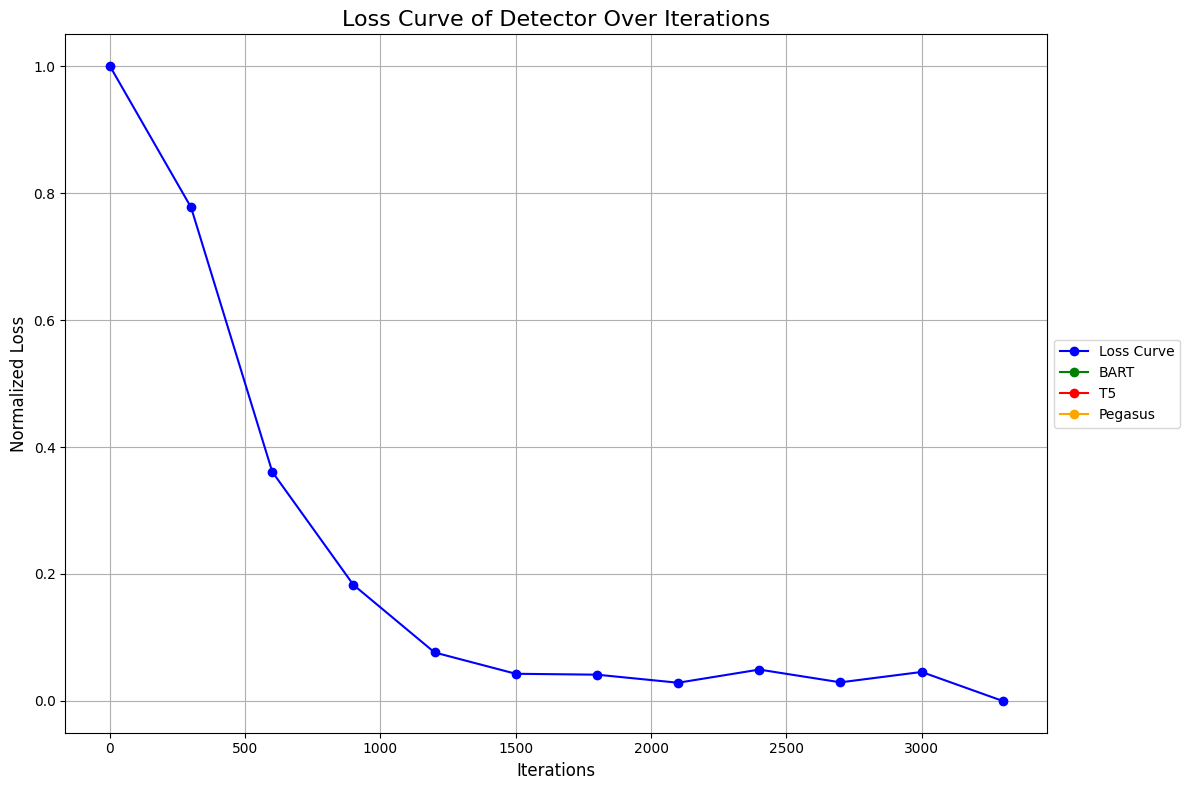

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 8))

iterations = list(np.arange(len(loss_detector))*300)
# Normalize individual data for separate lines
l = ppotrainersteps[0]
l_normalized = (l - np.min(l)) / (np.max(l) - np.min(l))

m = ppotrainersteps[1]
m_normalized = (m - np.min(m)) / (np.max(m) - np.min(m))

n = ppotrainersteps[1]
n_normalized = (n - np.min(n)) / (np.max(n) - np.min(n))

loss_detector = (loss_detector - np.min(loss_detector)) / (np.max(loss_detector) - np.min(loss_detector))
# Plot normalized loss curve
plt.plot(iterations, loss_detector, marker='o', linestyle='-', color='b', label='Loss Curve')

# Plot normalized individual data
plt.plot(iterations, l_normalized, marker='o', linestyle='-', color='g', label='BART')
plt.plot(iterations, m_normalized, marker='o', linestyle='-', color='r', label='T5')
plt.plot(iterations, n_normalized, marker='o', linestyle='-', color='orange', label='Pegasus')

# Set title and labels
plt.title('Loss Curve of Detector Over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Normalized Loss', fontsize=12)
plt.grid(True)

# Adjust legend location and format
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# Show plot
plt.show()

### Step 4: Evaluating on Validation Dataset

In [ ]:
validate_df

,id,wiki_intro,generated_intro
0,56694597,Mikalai Dvornikau (Belarusian: Мікалай Мікалае...,Mikalai Dvornikau (Belarusian: Мікалай Мікалае...
1,42560060,Mary Osborn (born in 1940) is a L'Oréal-UNESCO...,Mary Osborn (born in 1940) is a painter and sc...
2,13347915,Tuomas Kantelinen (born 22 September 1969 in K...,Tuomas Kantelinen (born 22 September 1969 in H...
3,30174309,OpenNebula is a cloud computing platform for ...,OpenNebula is a cloud computing platform that...
4,202418,"The Atlantic puffin , also known as the common...","The Atlantic puffin , also known as the common..."
...,...,...,...
14995,31462577,The Café Bohemia is a jazz club located at 15 ...,The Café Bohemia is a jazz club located in the...
14996,6162151,"Baabda District (, transliteration: Qada' Baab...","Baabda District (, transliteration: Qada' Baab..."
14997,23739408,Lucien Leuwen is the second major novel writte...,Lucien Leuwen is the second major novel by Bel...
14998,16194652,"Perdón, viejita is a 1927 silent Argentine fil...","Perdón, viejita is a 1927 silent Argentine-Spa..."


In [29]:
scores = []
logs = []
dt_od = detector_model.to(device)
for i in validate_df['wiki_intro']:
  tok = detector_tokenizer(i,return_tensors="pt",padding = True,truncation = True).to(device)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
  logs.append(logits[0][0])


for i in validate_df['generated_intro']:
  tok = detector_tokenizer(i,return_tensors="pt",padding = True,truncation = True).to(device)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
  logs.append(logits[0][0])



OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 6.06 MiB is free. Process 10576 has 27.66 GiB memory in use. Including non-PyTorch memory, this process has 19.85 GiB memory in use. Of the allocated memory 19.36 GiB is allocated by PyTorch, and 174.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
radar_scores = []
logs = []
dt_od = RADAR_model.to(device)
for i in validate_df['wiki_intro']:
  tok = RADAR_tokenizer(i,return_tensors="pt",padding = True,truncation = True).to(device)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
  logs.append(logits[0][0])


for i in validate_df['generated_intro']:
  tok = RADAR_tokenizer(i,return_tensors="pt",padding = True,truncation = True).to(device)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
  logs.append(logits[0][0])


In [ ]:
baseline_score = []
logs = []
dt_od = saved_baseline_model.to(device)
for i in validate_df['wiki_intro']:
  tok = saved_baseline_tokenizer(i,return_tensors="pt",padding = True,truncation = True).to(device)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
  logs.append(logits[0][0])


for i in validate_df['generated_intro']:
  tok = saved_baseline_tokenizer(i,return_tensors="pt",padding = True,truncation = True).to(device)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
  logs.append(logits[0][0])


In [ ]:
labels = [0]*50 + [1]*50

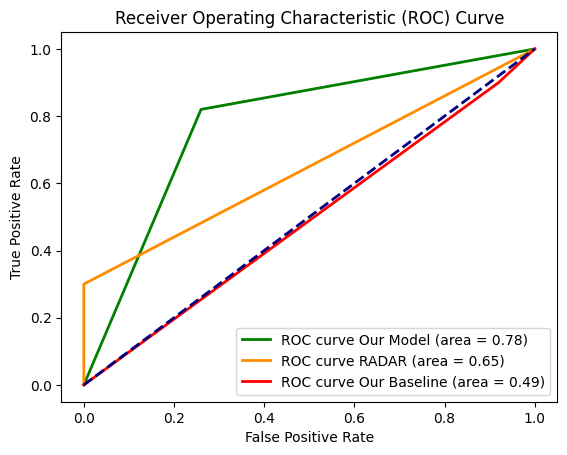

AUROC: 0.7799999999999999


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = label
y_score = scores
# Assuming 'y_true' contains true labels and 'y_score' contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_score)
fpr1, tpr1, threshold1 = roc_curve(y_true, radar_score)
fpr2, tpr2, threshold2 = roc_curve(y_true, baseline_score)
roc_auc2 = auc(fpr2,tpr2)
roc_auc1 = auc(fpr1, tpr1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='g', lw=2, label='ROC curve Our Model (area = {:.2f})'.format(roc_auc))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve RADAR (area = {:.2f})'.format(roc_auc1))
plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve Our Baseline (area = {:.2f})'.format(roc_auc2))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('AUROC:', roc_auc)